In [885]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import glob
from IPython.display import Audio
from tqdm.notebook import tqdm
from src.modules.training.datasets.to_2d.spec import Spec
from functools import partial
import torchaudio
from src.modules.training.datasets.to_2d.spec_normalize import SpecNormalize
import torch

# Load audio files

In [886]:
SPECIES = "blnmon1"
N_MAX = 10

In [887]:
audio_files = glob.glob(f"../data/raw/train_audio/{SPECIES}/*.ogg")
audio_files = audio_files[:min(N_MAX, len(audio_files))]

In [888]:
audio = dict()
sr = 32000
for audio_file in tqdm(audio_files):
    audio[audio_file], _ = librosa.load(audio_file)

  0%|          | 0/10 [00:00<?, ?it/s]

In [893]:
class SpecNormalizeMedian:
    def __init__(self):
        self.eps = 1
    
    def __call__(self, x):
        
        # med = torch.median(x, dim=-1).values
        # x = x - med.unsqueeze(-1)
        # 
        # print(x.min(),x.max(),x.mean(),x.std(),x.median())
        # 
        # x = x - x.min() / 1
        # 
        # print(x.min(),x.max(),x.mean(),x.std(),x.median())
                # Remove horizontal median, stripes
        
        old_min = x.min()

        med = torch.quantile(x, 0.2, dim=-1)
        x = x - med.unsqueeze(-1)
        # x = torch.pow(x,(-x.min()/x + 1))
        x = x - x.min()        
        
        x = torch.log10(x + self.eps)
        
        nan_min = torch.min(x[~torch.isnan(x)])        
        x = torch.nan_to_num(x, nan=nan_min, posinf=torch.nan, neginf=nan_min)
        
        # print(torch.isnan(x).sum()/x.numel())
        # plt.hist(x.numpy().flatten())        
        # plt.show()     
            
    
        # med2 = torch.median(x,dim=-2).values
        # # Removes vertica stripes
        # x = x - med2.unsqueeze(-2)
        # x = (x - x.min()) / (x.max() - x.min())
           
        # middle = x.shape[-1] // 2    
        # apply to right half only
        
        # x[:, middle:] = x[:, middle:] - med.values.unsqueeze(-1)
        return x

In [894]:
def make_spec(audio, sr, duration=5) -> np.array:
    if len(audio) > sr * duration:
        audio = audio[:sr * duration]
    if len(audio) < sr * duration:
        audio = np.pad(audio, (0, sr * duration - len(audio)))
    # returns height x width
    cls = Spec(spec=partial(torchaudio.transforms.MelSpectrogram), output_shape=(512,512), scale=SpecNormalizeMedian(), seqeunce_length=160000*1)
    
    # to tensor
    t = torch.tensor(audio)
    t = cls(t)
    return t.numpy()

In [895]:
def show(audio):
    D = make_spec(audio, sr)
    
    print(D.shape)
    
    plt.figure(figsize=(10, 5))
    
    plt.imshow(D, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    
    # set scale
    # plt.clim(0, 2.5)

    plt.show()

(512, 512)


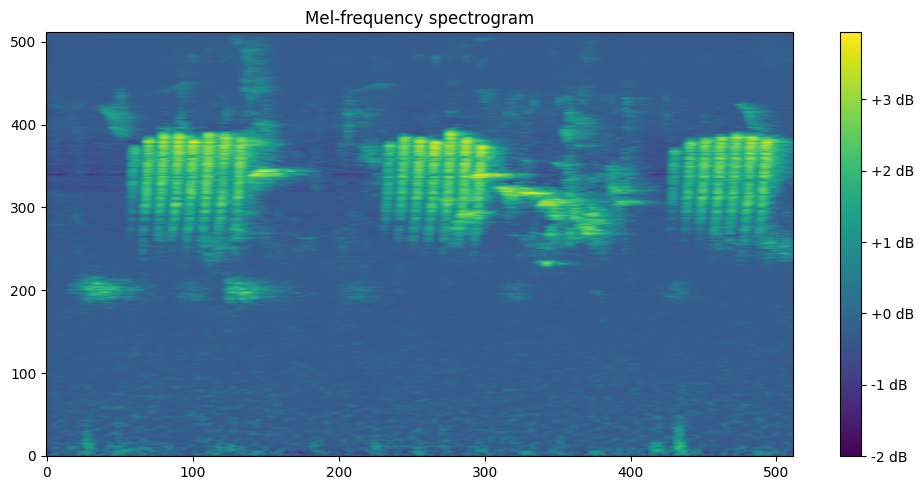

(512, 512)


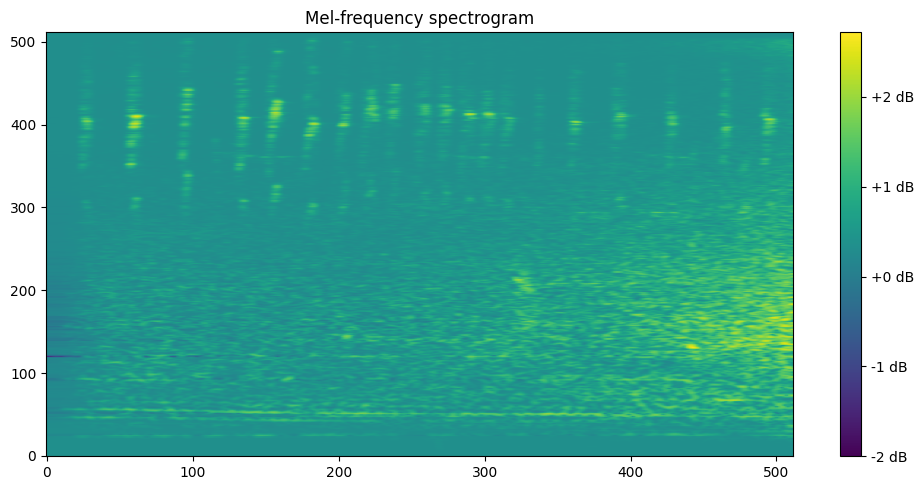

(512, 512)


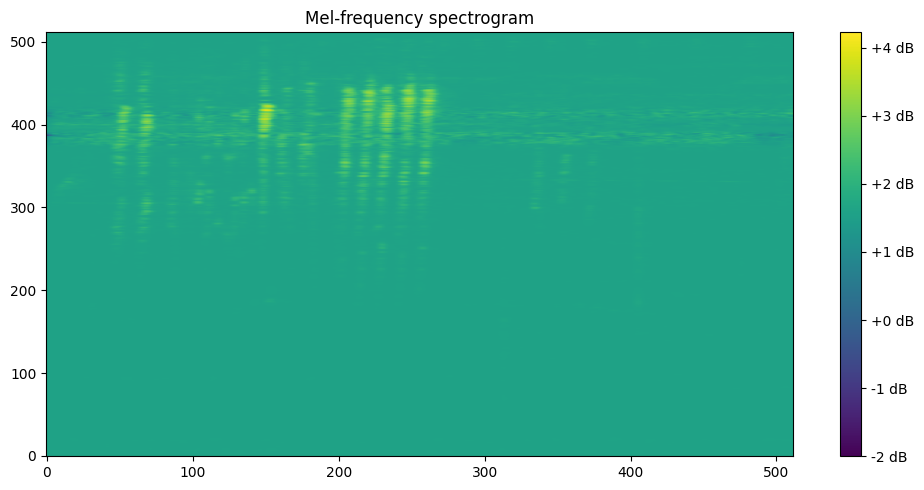

In [896]:
for audio_file in audio_files[:3]:
    show(audio[audio_file])
    Audio(audio[audio_file], rate=sr)